In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from aux import LogSumExp

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [45]:
def lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    if N==0: return lq0(x_,rho_,u_)
    w=np.zeros((N,x_.shape[1]))
    w[0,:]=lq0(x_,rho_,u_)
    lJ=np.zeros(x_.shape[1])
    for n in range(N):
        #print(x_[0,0])
        x_,rho_,u_,tlJ,_,_,_=flow(1,x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')
        lJ=lJ+tlJ
        w[n,:]=lq0(x_,rho_,u_)+tlJ
    # end for
    return LogSumExp(w)-np.log(N),x_


def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x_.shape[1])
    if steps==0: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps+1,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps+1,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps+1,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps):
        #print(str(n+1)+'/'+str(steps),end='\r')
        if direction=='fwd': x_,rho_,u_,tmplJ=forward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=x,rho,u
    lJ=-lm(rho_)
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    lJ=lJ+lm(rho_)
    u_=(u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    for l in range(L):
        rhot = rho_  + epsilon*grad_lp(x_)/2
        x_    = x_   - epsilon*grad_lm(rhot)
        rho_  = rhot + epsilon*grad_lp(x_)/2
    # end for
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho))#(1-np.exp(-np.abs(rho))) #(M,d)->(M,d)
def lap_Qm(p)  : return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,z): return 0.5*np.sin(2*x+u)+0.5

In [46]:
# target specification
def lp(x): return gauss_lp(x,0,1)
def grad_lp(x): return -x

# ref specification
mu0=3
sigma0=0.3
def lq0(x,rho,u): return gauss_lp(x,mu0,sigma0)+lap_lm(rho)
def randq0(size): return mu0+sigma0*np.random.randn(1,size),np.random.laplace(size=(1,size)),np.random.rand(size)

ss=1000
q0_sample=mu0+sigma0*np.random.randn(1,ss)

In [47]:
size=1000
x=np.linspace(-4,4,size)[np.newaxis,:]
rho=np.random.laplace(size=(1,size))
u=np.random.rand(size)
lq,newx=lqN(x,rho,u,N=100,lq0=lq0,L=50,epsilon=0.1,grad_lp=grad_lp,xi=np.pi/16)

(array([  6.,  29.,  85., 176., 266., 215., 151.,  50.,  19.,   3.]),
 array([-3.16716717, -2.51129129, -1.85541542, -1.19953954, -0.54366366,
         0.11221221,  0.76808809,  1.42396396,  2.07983984,  2.73571572,
         3.39159159]),
 <BarContainer object of 10 artists>)

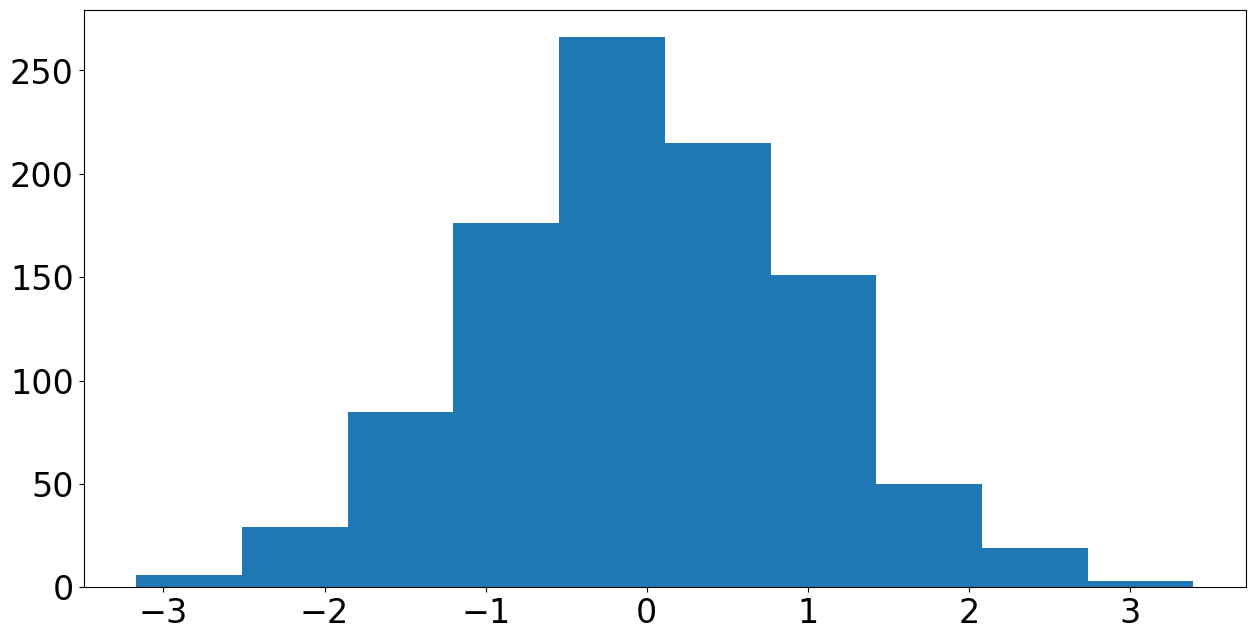

In [48]:
plt.hist(newx[0,:])

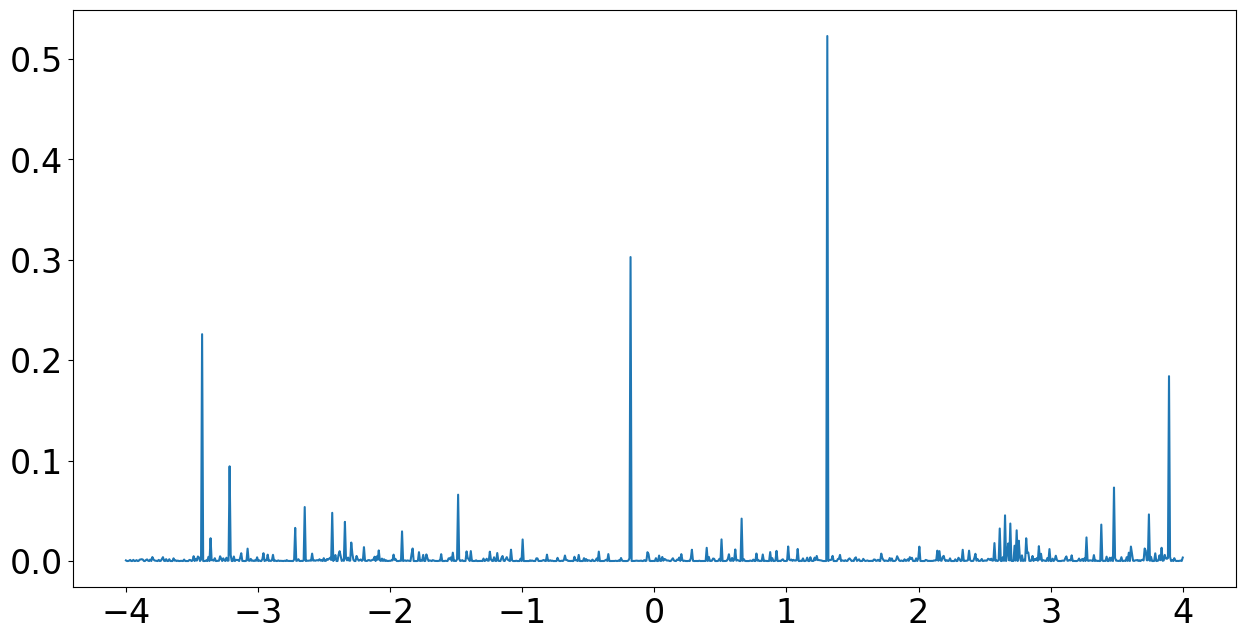

In [40]:
plt.plot(x[0,:],np.exp(lq))

In [ ]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(lq0(ttx[np.newaxis,:])))
plt.hist(q0_sample[0,:],alpha=0.5,density=True,bins=50);

## Forward pass

In [25]:
# settings
steps=100
x=q0_sample
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16
direction='fwd'

In [26]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction)

In [27]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

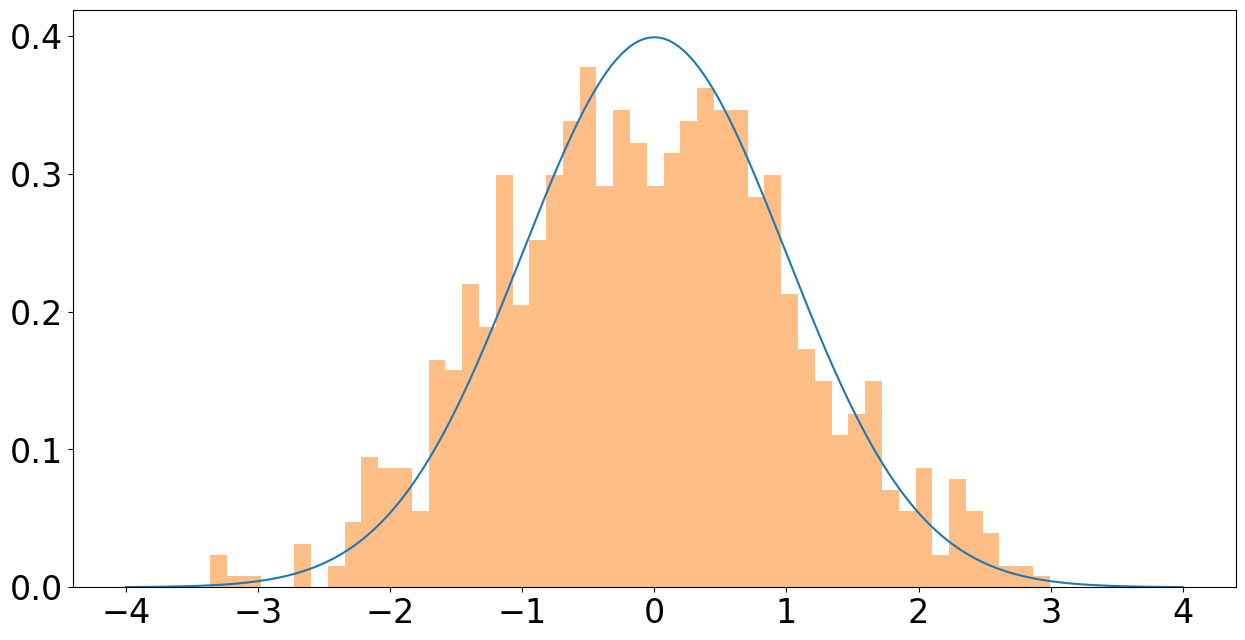

In [28]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])))
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50);

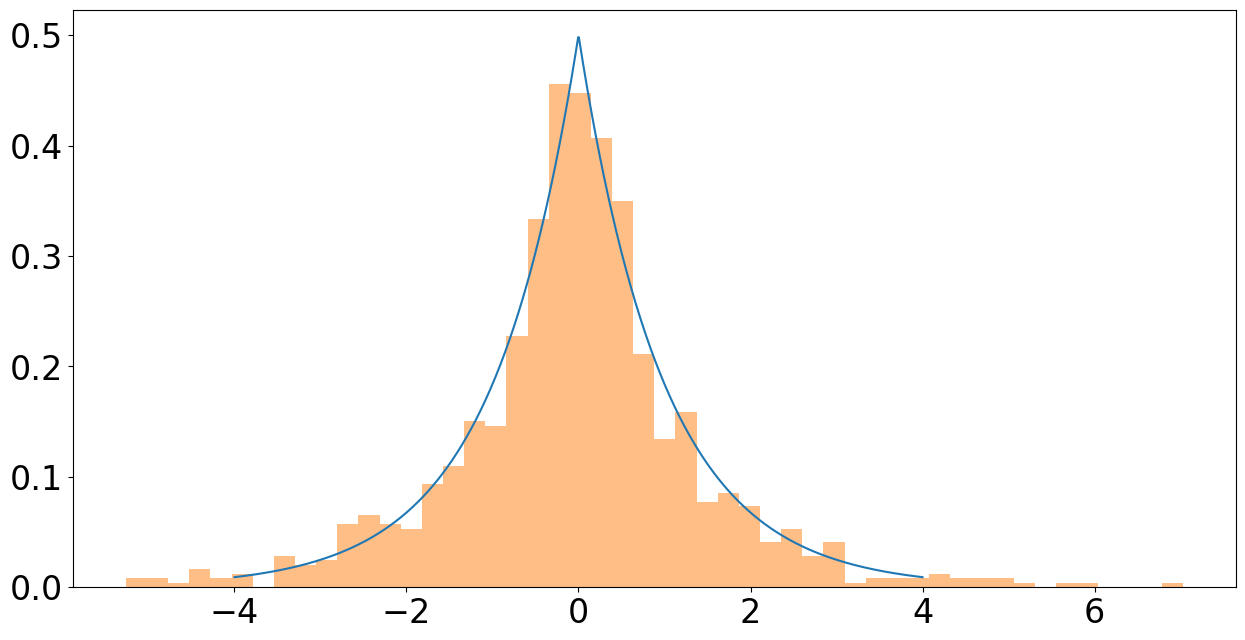

In [29]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50);

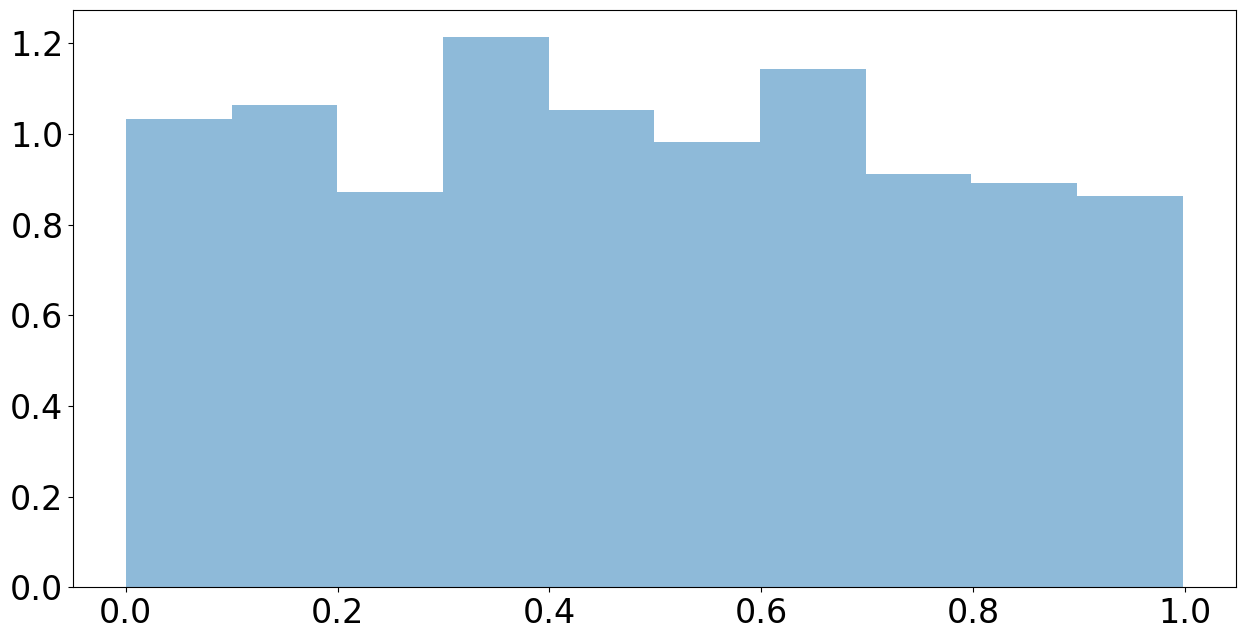

In [30]:
plt.hist(up,alpha=0.5,density=True,bins=10);

## Backward pass

In [31]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

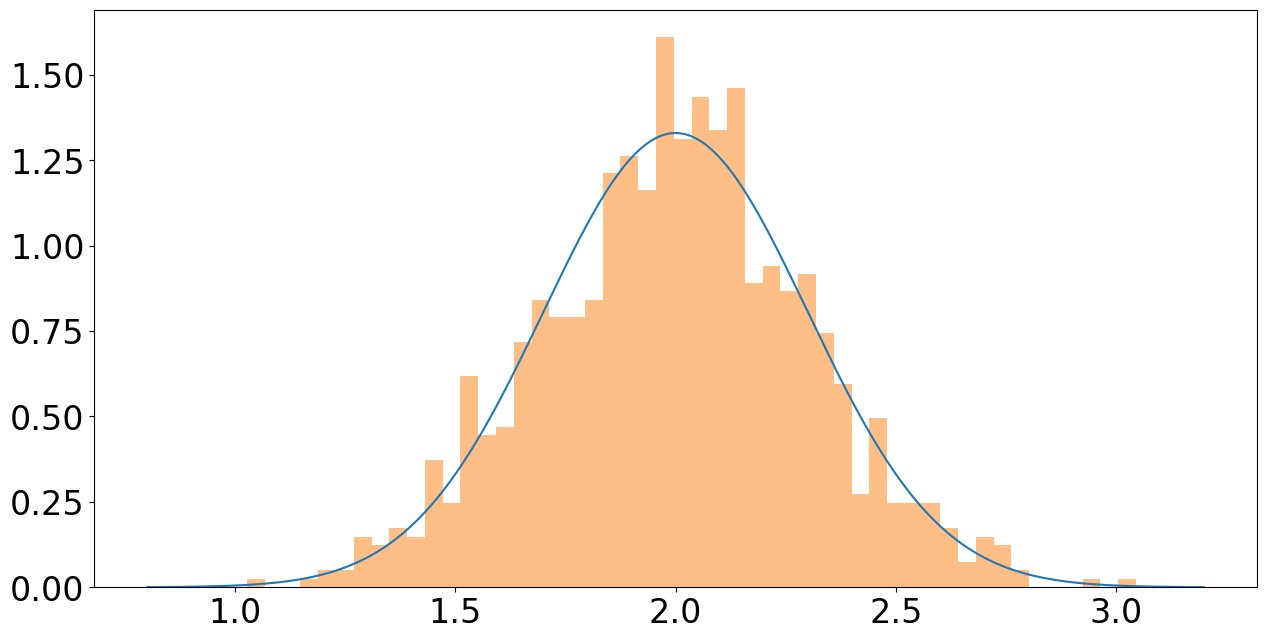

In [34]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)))
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50);

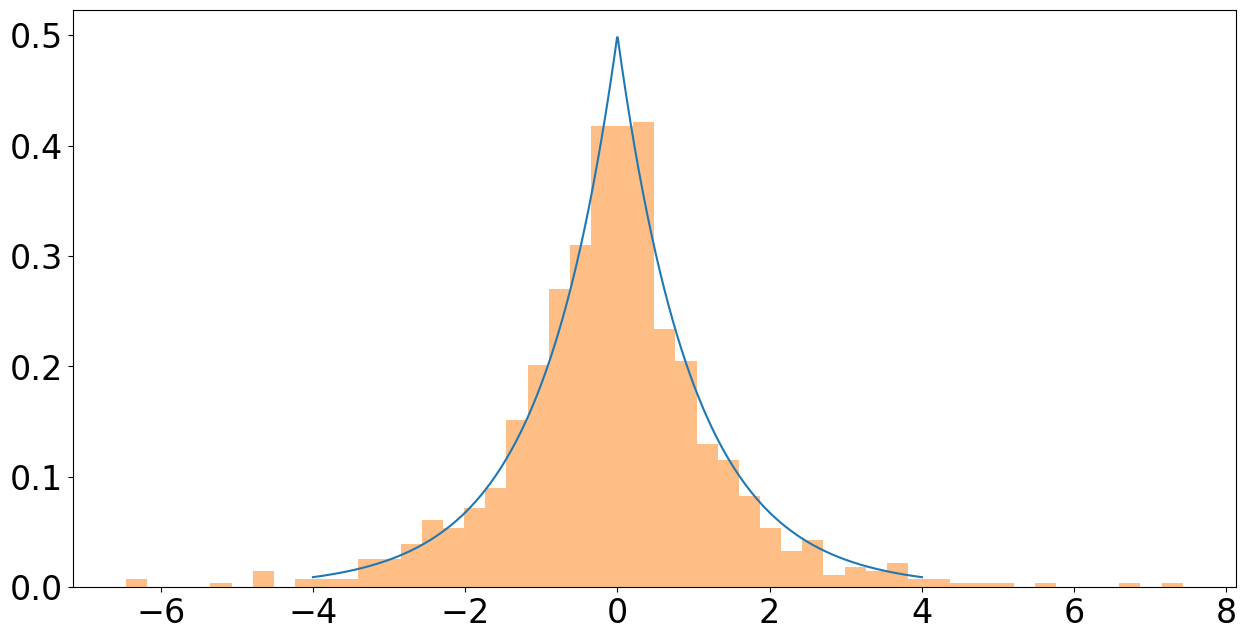

In [35]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50);

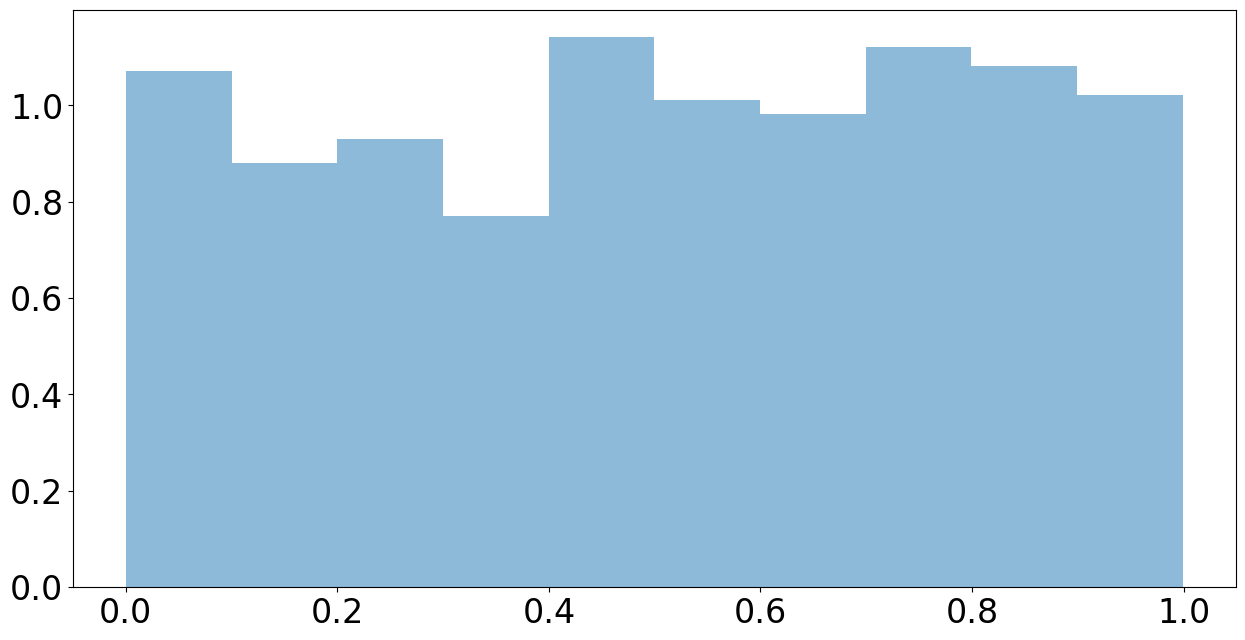

In [36]:
plt.hist(upp,alpha=0.5,density=True,bins=10);

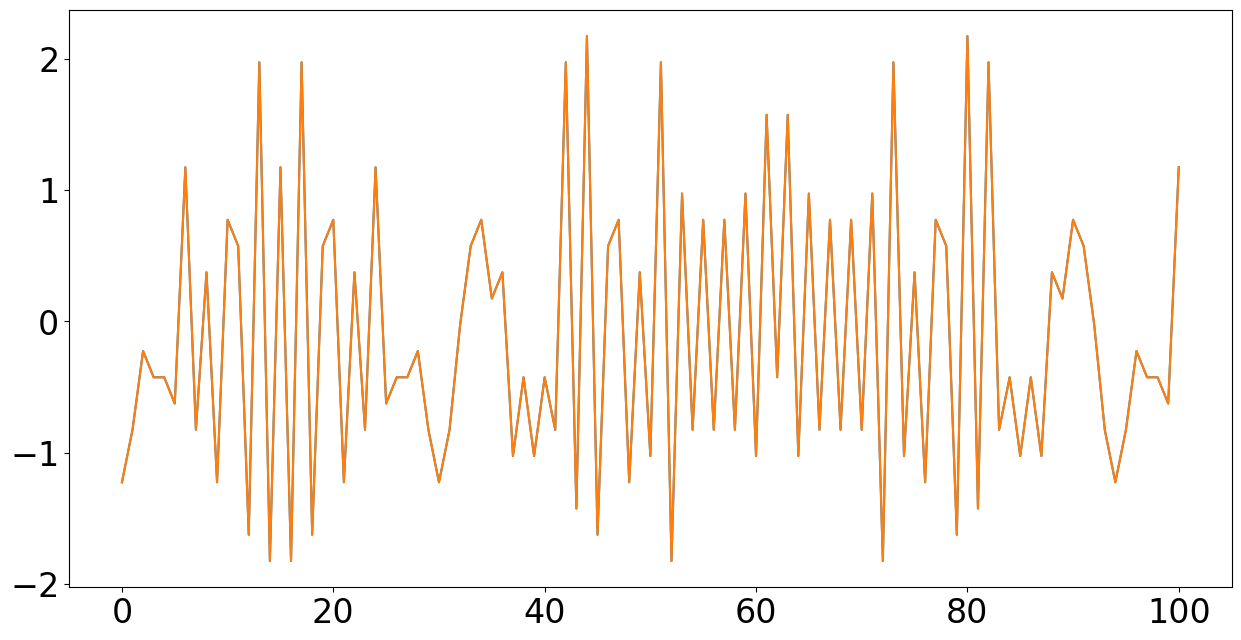

In [37]:
plt.plot(np.arange(0,steps+1),np.flip(xs[:,0,0]))
plt.plot(np.arange(0,steps+1),xps[:,0,0])

## Density